구글 드라이브 마운트 + 프로젝트 경로 고정

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path

PROJECT_DIR = Path("/content/drive/MyDrive/P-project(SignSong)/rhythm-nlp")
DATA_DIR = PROJECT_DIR / "data"
OUT_DIR  = PROJECT_DIR / "output"

print("PROJECT_DIR exists? ->", PROJECT_DIR.exists())
print("folders:", [p.name for p in PROJECT_DIR.iterdir()])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_DIR exists? -> True
folders: ['data', 'output', 'src']


In [ ]:
!pip install -U pip setuptools wheel
!pip install librosa==0.10.2.post1 soundfile

In [ ]:
!pip install -q "jedi>=0.16"

In [ ]:
from pathlib import Path

song_id = "family_song"   # ※※※ need custom! ※※※

audio_path  = DATA_DIR / "audio" / f"{song_id}.mp3"
lyrics_path = DATA_DIR / "lyric" / f"{song_id}.txt"

print("audio:", audio_path, "exists:", audio_path.exists())
print("lyric:", lyrics_path, "exists:", lyrics_path.exists())

audio: /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/data/audio/family_song.mp3 exists? True
lyric: /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/data/lyric/family_song.txt exists? True


음원 기반 비트 시점[] 추출

In [ ]:
import librosa
import numpy as np
import pandas as pd

# 음원 로드
y, sr = librosa.load(audio_path, sr=None)

# 리듬 성분을 더 잘 잡기 위해 퍼커시브(타악기 리듬)만 분리
y_harm, y_perc = librosa.effects.hpss(y)

# onset -> beat
onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr)
tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

beats_df = pd.DataFrame({
    "beat_index": np.arange(len(beat_times), dtype=int),
    "time_sec": beat_times
})

beats_csv = OUT_DIR / "beat" / f"{song_id}_beats.csv"
beats_df.to_csv(beats_csv, index=False, encoding="utf-8-sig")

print("tempo:", tempo)
print("beat count:", len(beats_df))
print("saved ->", beats_csv)
beats_df.head()

/tmp/ipython-input-3812959689.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


tempo: [119.68085106]
beat count: 104
saved -> /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/output/beat/family_song_beats.csv


,beat_index,time_sec
0,0,5.205333
1,1,5.706667
2,2,6.218667
3,3,6.656000
4,4,7.210667


onset: 음악적 사건 전환 시작 시점

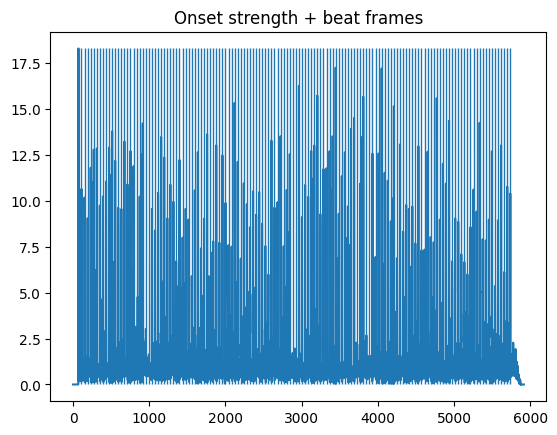

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(onset_env)
plt.vlines(beat_frames, 0, onset_env.max(), linewidth=1)
plt.title("Onset strength + beat frames")
plt.show()

가사 전처리+형태소 분석+TopN 핵심단어 추출



*   Boat_song, Dreamlovehope_song: N=20
*   Family_song: N=30


In [ ]:
!pip -q install konlpy JPype1

In [ ]:
import re, json
from collections import Counter
from konlpy.tag import Okt

text = lyrics_path.read_text(encoding="utf-8")

text = re.sub(r"\([^)]*\)", " ", text)
text = re.sub(r"[^가-힣0-9\s]", " ", text)
text = re.sub(r"\s+", " ", text).strip()

okt = Okt()   # 형태소 분석기 로드
pos = okt.pos(text, norm=True, stem=True)

tokens = []
for w, t in pos:
    if t in {"Noun", "Adjective"} and len(w) >= 1:
        tokens.append(w)

# 최소 불용어 기본 셋 리스트
stopwords = {"것","수","나","너","우리","저","그","이","좀","정말","하다","되다","있다","없다"}
tokens = [t for t in tokens if t not in stopwords]

topN = 30   # ※※※ need custom! ※※※
top = Counter(tokens).most_common(topN)

keywords_json = OUT_DIR / "keyword" / f"{song_id}_keywords_Top20.json"
payload = {"song_id": song_id, "topN": topN, "keyword": [{"word": w, "count": c} for w, c in top]}
keywords_json.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding="utf-8")

print("saved ->", keywords_json)
top

saved -> /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/output/keyword/family_song_keywords_Top20.json


[('가족', 4),
 ('엄마', 2),
 ('아빠', 2),
 ('행복하다', 2),
 ('오빠', 2),
 ('손', 2),
 ('언니', 2),
 ('가장', 2),
 ('아침', 1),
 ('잠', 1),
 ('뽀뽀', 1),
 ('이제', 1),
 ('정성', 1),
 ('가득', 1),
 ('요리', 1),
 ('맛있다', 1),
 ('따뜻하다', 1),
 ('잡고', 1),
 ('학교', 1),
 ('재밌다', 1),
 ('소꿉놀이', 1),
 ('재미있다', 1),
 ('달콤하다', 1),
 ('말', 1),
 ('예쁘다', 1),
 ('멜로디', 1),
 ('하하호호', 1),
 ('웃음', 1),
 ('가득하다', 1),
 ('집', 1)]

음원 기반 wav 변환 후 6초 단위 split


-> STT(음원 -> 텍스트+타임스탬프) 각각 추출

In [ ]:
!pip -q install faster-whisper

음원 기반 wav 변환 후 6초 단위 split -> STT 각각 추출

In [ ]:
!apt-get -qq update
!apt-get -qq install -y ffmpeg

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
from pathlib import Path
import subprocess

PROJECT_DIR = Path("/content/drive/MyDrive/P-project(SignSong)/rhythm-nlp")
DATA_DIR = PROJECT_DIR / "data"
OUT_DIR  = PROJECT_DIR / "output"

song_id = "family_song"   # ※※※ need custom! ※※※

tmp_dir = OUT_DIR / "tmp_chunks" / song_id
tmp_dir.mkdir(parents=True, exist_ok=True)

mp3_path = DATA_DIR / "audio" / f"{song_id}.mp3"
wav_path = tmp_dir / f"{song_id}_16k_mono.wav"

subprocess.run([
    "ffmpeg", "-y", "-i", str(mp3_path),
    "-ac", "1", "-ar", "16000",
    str(wav_path)
], check=True)

print("saved wav ->", wav_path, "exists?", wav_path.exists())

saved wav -> /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/output/tmp_chunks/family_song/family_song_16k_mono.wav exists? True


1201 update)

demucs 기반 동요에서 보컬 분리 후 STT 전달(반주가 음성 특성 덮는 것을 최대한 방지하기 위함)

In [ ]:
!pip -q install demucs

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch, subprocess, sys

cuda = torch.version.cuda  # GPU 없으면 None
print("torch:", torch.__version__, "cuda:", cuda)

if cuda:
    major, minor = cuda.split(".")[:2]
    cu = f"cu{major}{minor}"  # "12.1" -> "cu121"
    index_url = f"https://download.pytorch.org/whl/{cu}"
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torchcodec", "--index-url", index_url])
else:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torchcodec"])

import torchcodec
print("torchcodec installed:", torchcodec.__version__)

torch: 2.9.0+cu126 cuda: 12.6
torchcodec installed: 0.9.0+cu126


In [ ]:
demucs_out = OUT_DIR / "demucs"
!python -m demucs -n htdemucs --two-stems=vocals -o "{demucs_out}" "{mp3_path}"

vocals_path = demucs_out / "htdemucs" / song_id / "vocals.wav"
vocals_16k = OUT_DIR / f"{song_id}_vocals_16k.wav"

# 보컬 wav를 16k mono + 간단한 EQ/정규화로 정제
import subprocess
subprocess.run([
    "ffmpeg","-y","-i", str(vocals_path),
    "-ac","1","-ar","16000",
    "-af","loudnorm,highpass=f=80,lowpass=f=8000",
    str(vocals_16k)
], check=True)

print(vocals_16k, vocals_16k.exists())

Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/output/demucs/htdemucs
Separating track /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/data/audio/family_song.mp3
100%|████████████████████████████████████████████████████████████████████████| 64.35/64.35 [00:05<00:00, 12.68seconds/s]
/usr/local/lib/python3.12/dist-packages/torchaudio/__init__.py:178: UserWarning: The 'encoding' parameter is not fully supported by TorchCodec AudioEncoder.
  return save_with_torchcodec(
/usr/local/lib/python3.12/dist-packages/torchaudio/__init__.py:178: UserWarning: The 'bits_per_sample' parameter is not directly supported by TorchCodec AudioEncoder.
  return save_with_torchcodec(
/content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/output/family_song_vocals_16k.wav True


In [ ]:
import os
os.environ["HF_HOME"] = "/content/drive/MyDrive/hf_cache"
os.environ["HUGGINGFACE_HUB_CACHE"] = "/content/drive/MyDrive/hf_cache/hub"

In [ ]:
import soundfile as sf
import numpy as np
import pandas as pd
import re
import torch
from faster_whisper import WhisperModel

device = "cuda" if torch.cuda.is_available() else "cpu"
compute = "float16" if device == "cuda" else "int8"

model = WhisperModel("large-v3", device=device, compute_type=compute)

keywords_json = OUT_DIR / "keyword" / f"{song_id}_keywords_Top20.json"
kw = json.loads(keywords_json.read_text(encoding="utf-8"))
keywords = [x["word"] for x in kw["keyword"]]

# WAV 로드
wav_path = vocals_16k
y, sr = sf.read(str(wav_path))
assert sr == 16000
if y.ndim > 1:
    y = y.mean(axis=1)

duration = len(y) / sr
print("duration(sec):", duration)

# ※※※ need custom! ※※※
chunk_sec = 14.0
overlap_sec = 4.0   # boat_song만 6.0, 나머지는 4.0
hop_sec = chunk_sec - overlap_sec

def clean_ko(s: str) -> str:
    s = re.sub(r"[^가-힣0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

base_prompt = "동요에 나온 단어들: " + ", ".join(keywords)

def norm_token(x: str) -> str:
    x = re.sub(r"\s+", "", str(x))
    x = re.sub(r"[^가-힣0-9]", "", x)
    return x

def rms_db(x):
    r = float(np.sqrt(np.mean(x*x) + 1e-12))
    return 20*np.log10(r + 1e-12)

all_segs = []
carry_prompt = ""

# =========================
# tail 짧은 chunk(짤림 현상) 방지:
# - 시작 시각 리스트를 미리 만들고
# - 마지막 chunk는 duration-chunk_sec로 고정
# =========================
starts = list(np.arange(0, max(0.0, duration - chunk_sec) + 1e-6, hop_sec))
last_start = max(0.0, duration - chunk_sec)
if (not starts) or (abs(starts[-1] - last_start) > 1e-6):
    starts.append(last_start)

for chunk_idx, start in enumerate(starts):
    end = min(start + chunk_sec, duration)
    i0, i1 = int(start * sr), int(end * sr)
    chunk = y[i0:i1]

    chunk_path = OUT_DIR / "tmp_chunks" / song_id / f"{song_id}_chunk_{chunk_idx:04d}_{start:.2f}_{end:.2f}.wav"
    sf.write(str(chunk_path), chunk, sr)

    prompt = base_prompt
    if carry_prompt:
        prompt = prompt + " | 직전 문맥: " + carry_prompt

    segments, info = model.transcribe(
        str(chunk_path),
        language="ko",
        vad_filter=False,                   # 노래/반주 구간 잡음 줄이기
        condition_on_previous_text=False,   # chunk 내부 문맥 유지
        temperature=[0.0, 0.2, 0.4, 0.6],
        beam_size=12,
        best_of=5,
        initial_prompt=prompt,
        word_timestamps=True
    )

    segments = list(segments)

    last_text = ""
    for s in segments[-5:]:
        last_text += " " + (s.text or "")
    last_text = clean_ko(last_text).strip()
    carry_prompt = last_text[-60:] if last_text else ""

    # keep 구간: overlap 구간 큰 만큼 중앙(hop 구간)만 채택, 중복 오탐 방지
    # keep 구간은 오버랩의 반절 기준
    keep_lo = start + overlap_sec / 2.0
    keep_hi = end   - overlap_sec / 2.0

    # 첫 chunk/마지막 chunk는 예외 처리
    if start <= 1e-6:
        keep_lo = start
    if end >= duration - 1e-6:
        keep_hi = end
    if keep_lo >= keep_hi:
        keep_lo, keep_hi = start, end

    print(f"[chunk {chunk_idx:04d}] {start:6.2f}~{end:6.2f} keep={keep_lo:5.2f}~{keep_hi:5.2f} rms(dB): {rms_db(chunk):6.1f}")

    # keep 구간에 탐지되는 segment만 최종 저장
    segments_keep = []
    for s in segments:
        seg_s = start + float(s.start)
        seg_e = start + float(s.end)
        if (seg_e > keep_lo) and (seg_s < keep_hi):
            segments_keep.append(s)

    for s in segments_keep:
        raw = s.text or ""
        c = clean_ko(raw)

        seg_s = start + float(s.start)
        seg_e = start + float(s.end)

        words_meta = []
        if getattr(s, "words", None):
            for w in s.words:
                t0 = start + float(w.start)
                t1 = start + float(w.end)
                wn = norm_token(w.word or "")
                # keep 구간에 들어오는 terms만 최종 채택
                if wn and (t1 > keep_lo) and (t0 < keep_hi):
                    words_meta.append({"wn": wn, "t0": t0, "t1": t1})

        all_segs.append({
            "chunk_start": start,
            "chunk_end": end,
            "seg_start": seg_s,
            "seg_end": seg_e,
            "raw_text": raw,
            "clean_text": c,
            "clean_nospace": c.replace(" ", ""),
            "words": words_meta
        })

seg_df = pd.DataFrame(all_segs).sort_values("seg_start").reset_index(drop=True)
print("total segments:", len(seg_df))
seg_df.head(20)

duration(sec): 58.8586875
[chunk 0000]   0.00~ 12.00 keep= 0.00~10.00 rms(dB):  -27.4
[chunk 0001]   8.00~ 20.00 keep=10.00~18.00 rms(dB):  -29.0
[chunk 0002]  16.00~ 28.00 keep=18.00~26.00 rms(dB):  -29.6
[chunk 0003]  24.00~ 36.00 keep=26.00~34.00 rms(dB):  -29.7
[chunk 0004]  32.00~ 44.00 keep=34.00~42.00 rms(dB):  -27.8
[chunk 0005]  40.00~ 52.00 keep=42.00~50.00 rms(dB):  -26.5
[chunk 0006]  46.86~ 58.86 keep=48.86~58.86 rms(dB):  -28.0
total segments: 14


,chunk_start,chunk_end,seg_start,seg_end,raw_text,clean_text,clean_nospace,words
0,0.000000,12.000000,0.000000,11.840000,"엄마와 함께, 아빠와 함께, 나도, 나도, 행복한 가족, 진잠을 깨우는 아빠,",엄마와 함께 아빠와 함께 나도 나도 행복한 가족 진잠을 깨우는 아빠,엄마와함께아빠와함께나도나도행복한가족진잠을깨우는아빠,"[{'wn': '엄마와', 't0': 0.0, 't1': 2.4}, {'wn': '..."
1,8.000000,20.000000,10.000000,12.800000,진잠을 깨우는 아빠 뽀뽀,진잠을 깨우는 아빠 뽀뽀,진잠을깨우는아빠뽀뽀,"[{'wn': '진잠을', 't0': 9.89, 't1': 10.54}, {'wn'..."
2,8.000000,20.000000,14.000000,14.860000,이제 일어나야지,이제 일어나야지,이제일어나야지,"[{'wn': '이제', 't0': 13.51, 't1': 14.16}, {'wn'..."
3,16.000000,28.000000,16.000000,27.900000,"요리, 정성이 가득 담긴 엄마 요리, 맛있게 먹으려, 하하호호, 넘어질까 내미는 따뜻",요리 정성이 가득 담긴 엄마 요리 맛있게 먹으려 하하호호 넘어질까 내미는 따뜻,요리정성이가득담긴엄마요리맛있게먹으려하하호호넘어질까내미는따뜻,"[{'wn': '정성이', 't0': 17.72, 't1': 18.48}, {'wn..."
4,8.000000,20.000000,17.160000,19.860000,정성이 가득 담긴 엄마,정성이 가득 담긴 엄마,정성이가득담긴엄마,"[{'wn': '정성이', 't0': 17.16, 't1': 18.46}]"
5,24.000000,36.000000,25.360000,28.760000,넘어질까 내미는 따뜻한 오빠 손,넘어질까 내미는 따뜻한 오빠 손,넘어질까내미는따뜻한오빠손,"[{'wn': '넘어질까', 't0': 25.36, 't1': 26.6}, {'wn..."
6,24.000000,36.000000,28.760000,30.920000,오빠 손잡고 학교 가자,오빠 손잡고 학교 가자,오빠손잡고학교가자,"[{'wn': '오빠', 't0': 28.759999999999998, 't1': ..."
7,32.000000,44.000000,32.000000,38.760000,재미는 언니와의 소꿉놀이 언니랑 재밌게 놀자,재미는 언니와의 소꿉놀이 언니랑 재밌게 놀자,재미는언니와의소꿉놀이언니랑재밌게놀자,"[{'wn': '언니와의', 't0': 34.0, 't1': 35.38}, {'wn..."
8,24.000000,36.000000,32.900000,35.980000,재미는 언니와의 소꿉,재미는 언니와의 소꿉,재미는언니와의소꿉,"[{'wn': '재미는', 't0': 32.900000000000006, 't1':..."
9,32.000000,44.000000,38.760000,40.620000,우리 가족,우리 가족,우리가족,"[{'wn': '우리', 't0': 38.76, 't1': 39.6}, {'wn':..."


In [ ]:
import re

ban_patterns = [
    r"구독", r"좋아요", r"부탁", r"광고", r"채널"
]

def is_noise(text: str) -> bool:
    t = text.replace(" ", "")
    return any(re.search(p, t) for p in ban_patterns)

seg_df2 = seg_df[~seg_df["clean_text"].apply(is_noise)].copy()
seg_df2 = seg_df2[seg_df2["clean_nospace"].str.len() >= 1].reset_index(drop=True)

print("before:", len(seg_df), "after:", len(seg_df2))
seg_df2.head(10)

before: 14 after: 14


,chunk_start,chunk_end,seg_start,seg_end,raw_text,clean_text,clean_nospace,words
0,0.0,12.0,0.00,11.84,"엄마와 함께, 아빠와 함께, 나도, 나도, 행복한 가족, 진잠을 깨우는 아빠,",엄마와 함께 아빠와 함께 나도 나도 행복한 가족 진잠을 깨우는 아빠,엄마와함께아빠와함께나도나도행복한가족진잠을깨우는아빠,"[{'wn': '엄마와', 't0': 0.0, 't1': 2.4}, {'wn': '..."
1,8.0,20.0,10.00,12.80,진잠을 깨우는 아빠 뽀뽀,진잠을 깨우는 아빠 뽀뽀,진잠을깨우는아빠뽀뽀,"[{'wn': '진잠을', 't0': 9.89, 't1': 10.54}, {'wn'..."
2,8.0,20.0,14.00,14.86,이제 일어나야지,이제 일어나야지,이제일어나야지,"[{'wn': '이제', 't0': 13.51, 't1': 14.16}, {'wn'..."
3,16.0,28.0,16.00,27.90,"요리, 정성이 가득 담긴 엄마 요리, 맛있게 먹으려, 하하호호, 넘어질까 내미는 따뜻",요리 정성이 가득 담긴 엄마 요리 맛있게 먹으려 하하호호 넘어질까 내미는 따뜻,요리정성이가득담긴엄마요리맛있게먹으려하하호호넘어질까내미는따뜻,"[{'wn': '정성이', 't0': 17.72, 't1': 18.48}, {'wn..."
4,8.0,20.0,17.16,19.86,정성이 가득 담긴 엄마,정성이 가득 담긴 엄마,정성이가득담긴엄마,"[{'wn': '정성이', 't0': 17.16, 't1': 18.46}]"
5,24.0,36.0,25.36,28.76,넘어질까 내미는 따뜻한 오빠 손,넘어질까 내미는 따뜻한 오빠 손,넘어질까내미는따뜻한오빠손,"[{'wn': '넘어질까', 't0': 25.36, 't1': 26.6}, {'wn..."
6,24.0,36.0,28.76,30.92,오빠 손잡고 학교 가자,오빠 손잡고 학교 가자,오빠손잡고학교가자,"[{'wn': '오빠', 't0': 28.759999999999998, 't1': ..."
7,32.0,44.0,32.00,38.76,재미는 언니와의 소꿉놀이 언니랑 재밌게 놀자,재미는 언니와의 소꿉놀이 언니랑 재밌게 놀자,재미는언니와의소꿉놀이언니랑재밌게놀자,"[{'wn': '언니와의', 't0': 34.0, 't1': 35.38}, {'wn..."
8,24.0,36.0,32.90,35.98,재미는 언니와의 소꿉,재미는 언니와의 소꿉,재미는언니와의소꿉,"[{'wn': '재미는', 't0': 32.900000000000006, 't1':..."
9,32.0,44.0,38.76,40.62,우리 가족,우리 가족,우리가족,"[{'wn': '우리', 't0': 38.76, 't1': 39.6}, {'wn':..."


핵심단어-비트 매핑 테이블 생성

In [ ]:
import json
import numpy as np
import pandas as pd
import re
from collections import Counter
from functools import lru_cache

# beats 로드
beats_csv = OUT_DIR / "beat" / f"{song_id}_beats.csv"
beats_df = pd.read_csv(beats_csv)
bt = beats_df["time_sec"].to_numpy()

keywords_json = OUT_DIR / "keyword" / f"{song_id}_keywords_Top20.json"
kw = json.loads(keywords_json.read_text(encoding="utf-8"))
keywords = [x["word"] for x in kw["keyword"]]

def norm_key(k: str) -> str:
    k = re.sub(r"\s+", "", str(k))
    k = re.sub(r"[^가-힣0-9]", "", k)
    return k

# 공통적으로 자주 등장하는 오탐지 단어 셋
STATIC_SYNONYMS = {
    "엄마": ["어머니"],
    "아빠": ["아버지"],
    "뽀뽀": ["쪽쪽", "쪽"],
    "재밌다": ["재미있다"],
    "재미있다": ["재밌다"],
}

# 용언/연결형 규칙 기반 variants(변형어 리스트)
def gen_predicate_variants(base: str) -> set[str]:
    vs = {base}

    # (A) ...하다 -> ...해/한/해요/합니다/했어/했어요
    if base.endswith("하다") and len(base) >= 3:
        pref = base[:-2]  # 행복하다 -> 행복
        vs |= {
            pref + "해", pref + "한",
            pref + "해요", pref + "합니다",
            pref + "했어", pref + "했어요",
        }
        return vs

    # (B) ...다 -> ...어서/아서/고/게/는/요
    if base.endswith("다") and len(base) >= 2:
        stem = base[:-1]  # 맛있다 -> 맛있
        vs |= {
            stem,
            stem + "어서",
            stem + "아서",
            stem + "고",
            stem + "게",
            stem + "는",
            stem + "요",
        }
        return vs

    # (C) ...고 -> 다/아서/어서/는
    if base.endswith("고") and len(base) >= 2:
        stem = base[:-1]  # 잡고 -> 잡
        vs |= {
            stem, stem + "다",
            stem + "아서",
            stem + "어서",
            stem + "는", stem + "요",
        }
        return vs

    return vs

# ※※※ need custom! ※※※

# STT에서 "근접 오타" 토큰 자동 채굴
# 정제된 STT(clean_text) 토큰 단위로만 채굴 -> 계산량/오탐 줄임
ENABLE_MINING = True

# family_song만 5, 나머지는 3
# 오탐 많을수록 크게
MINING_MIN_COUNT = 5
MIN_LEN_FOR_MINING = 2        # 탐색용 오탐 허용 범위의 최소 글자 수

def edit_dist_le1(a: str, b: str) -> bool:
    # 거리 0~1만 빠르게 체크
    if a == b:
        return True
    la, lb = len(a), len(b)
    if abs(la - lb) > 1:
        return False

    # 같은 길이: 치환 1회 이하
    if la == lb:
        diff = sum(x != y for x, y in zip(a, b))
        return diff <= 1

    # 길이 1 차이: 삽입/삭제 1회 이하
    if la > lb:
        a, b = b, a  # a가 짧게
    i = j = 0
    used = 0
    while i < len(a) and j < len(b):
        if a[i] == b[j]:
            i += 1; j += 1
        else:
            used += 1
            if used > 1:
                return False
            j += 1
    return True  # 남은 꼬리는 삽입 1회로 처리

# STT 토큰 빈도 계산 (곡마다 자동 생성)
tokens = []
for t in seg_df2["clean_text"].astype(str).tolist():
    tokens.extend(re.findall(r"[가-힣0-9]+", t))
token_counts = Counter(norm_key(x) for x in tokens if len(norm_key(x)) >= 2)

def mine_close_tokens(seed: str) -> set[str]:
    seed = norm_key(seed)
    if len(seed) < MIN_LEN_FOR_MINING:
        return set()

    out = set()
    for tok, c in token_counts.items():
        if c < MINING_MIN_COUNT:
            continue
        if abs(len(tok) - len(seed)) > 1:
            continue
        if edit_dist_le1(seed, tok):
            out.add(tok)
    return out

# 키워드별 variants 생성
variant_map = {}

for k in keywords:
    base = norm_key(k)
    vs = {base}

    # 상시 동의어
    for s in STATIC_SYNONYMS.get(base, []):
        vs.add(norm_key(s))

    # 용언/연결형 확장 (명사는 base만으로 충분)
    vs |= gen_predicate_variants(base)

    # STT 오타 채굴: variants의 길이>=3 토큰들로 추가 확장
    if ENABLE_MINING:
        for seed in list(vs):
            vs |= mine_close_tokens(seed)

    # 너무 짧은 변형 제거
    vs = {v for v in vs if len(v) >= 1}
    variant_map[k] = sorted(vs, key=len, reverse=True)

# variants 저장
variant_out = OUT_DIR / "keyword" / "variant_list" / f"{song_id}_variants_auto.json"
variant_out.write_text(json.dumps(variant_map, ensure_ascii=False, indent=2), encoding="utf-8")
print("saved variants ->", variant_out)

def all_occurrences(s: str, sub: str):
    start = 0
    L = len(sub)
    while True:
        p = s.find(sub, start)
        if p == -1:
            break
        yield p
        start = p + max(1, L)

def build_char_time_index(words_meta):
    word_join = ""
    char_t = []
    for w in words_meta:
        tok = w.get("wn", "")
        t0 = float(w.get("t0", 0.0))
        t1 = float(w.get("t1", t0))
        if not tok:
            continue
        word_join += tok

        if t1 <= t0 or len(tok) == 1:
            char_t.extend([t0] * len(tok))
        else:
            char_t.extend(np.linspace(t0, t1, num=len(tok), endpoint=False).tolist())
    return word_join, char_t

# variant_map과 beat mapping
beat_period = float(np.median(np.diff(bt)))  # 대략적인 비트 간격(초)
FUTURE_PENALTY = 0.15 * beat_period          # '더 늦은 탐지 비트'를 불리하게
MAX_SNAP = 0.45 * beat_period                # 최소 포함 시점 기준: 더 멀면 스냅X

def map_to_beat_biased(t):
    idx = int(np.searchsorted(bt, t, side="left"))
    cand = []
    for j in (idx-1, idx, idx+1):
        if 0 <= j < len(bt):
            b = float(bt[j])
            cost = abs(t - b) + (FUTURE_PENALTY if b > t else 0.0)
            cand.append((cost, j, b))

    cost, j, b = min(cand, key=lambda x: x[0])
    if abs(t - b) > MAX_SNAP:
        return None
    return j, b

min_gap_sec = 0.8 * beat_period   # 비트 간격 기반 중복 토큰 제외 범위

seg_texts = seg_df2["clean_nospace"].astype(str).tolist()
seg_starts = seg_df2["seg_start"].astype(float).to_numpy()
seg_ends   = seg_df2["seg_end"].astype(float).to_numpy()
seg_words  = seg_df2["words"].tolist()

rows = []
for k in keywords:
    vs = variant_map[k]

    hits = []
    for txt, st, ed, wmeta in zip(seg_texts, seg_starts, seg_ends, seg_words):
        # word_join에서 매칭 -> 해당 위치의 seg_start을 히트로 사용
        if isinstance(wmeta, list) and len(wmeta) > 0:
            word_join, char_t = build_char_time_index(wmeta)
            if not word_join:
                continue

            for v in vs:
                for p in all_occurrences(word_join, v):
                    if p < len(char_t):
                        hits.append(float(char_t[p]))

        # word가 비어있으면 seg 내 위치 비율로 보간
        else:
            seg_dur = float(ed - st)
            if seg_dur <= 0:
                continue
            for v in vs:
                for p in all_occurrences(txt, v):
                    ratio = p / max(1, len(txt))
                    hits.append(float(st + ratio * seg_dur))

    hits.sort()
    filtered = []
    for t in hits:
        if not filtered or (t - filtered[-1] >= min_gap_sec):
            filtered.append(t)

    best_by_beat = {}  # bidx -> (snap_err, lyric_time, beat_time)

    for t in filtered:
        res = map_to_beat_biased(t)
        if res is None:
            continue
        bidx, btime = res
        err = abs(float(t) - float(btime))
        old = best_by_beat.get(bidx)
        if (old is None) or (err < old[0]):
            best_by_beat[bidx] = (err, float(t), float(btime))

    for bidx, (err, t, btime) in sorted(best_by_beat.items(), key=lambda x: x[1][2]):
        rows.append({
            "song_id": song_id,
            "keyword": k,
            "lyric_time_sec": t,
            "beat_index": int(beats_df.loc[bidx, "beat_index"]),
            "time_sec": btime,
            "sign_id": "",
            "difficulty": "mid"
        })


mapping_all = pd.DataFrame(rows).sort_values("time_sec").reset_index(drop=True)
print("total notes:", len(mapping_all))
mapping_all.head(20)

out_csv = OUT_DIR / "mapping" / f"{song_id}_mapping_table_auto.csv"
mapping_all.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("saved ->", out_csv)

saved variants -> /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/output/keyword/variant_list/family_song_variants_auto.json
total notes: 35
saved -> /content/drive/MyDrive/P-project(SignSong)/rhythm-nlp/output/mapping/family_song_mapping_table_auto.csv


In [ ]:
# seg_df2에 norm 컬럼 추가 (정규화 통일)
seg_df2["clean_norm"] = seg_df2["clean_text"].astype(str).apply(norm_key)

report = []
examples = []

for k in keywords:
    vs = variant_map[k]  # variants(k)
    hit_rows = seg_df2[seg_df2["clean_norm"].apply(lambda t: any(v in t for v in vs))]

    report.append({
        "keyword": k,
        "num_variants": len(vs),
        "num_hits": len(hit_rows),
    })

    # 예시 3개만 저장
    for _, r in hit_rows.head(3).iterrows():
        examples.append({
            "keyword": k,
            "seg_start": r["seg_start"],
            "text": r["clean_text"],
        })

report_df = pd.DataFrame(report).sort_values(["num_hits","num_variants"], ascending=[True, False])
display(report_df)

ex_df = pd.DataFrame(examples)
display(ex_df)

,keyword,num_variants,num_hits
21,재미있다,9,0
24,예쁘다,8,0
8,아침,1,0
19,재밌다,9,1
15,맛있다,8,1
16,따뜻하다,7,1
17,잡고,7,1
22,달콤하다,7,1
10,뽀뽀,3,1
11,이제,1,1


,keyword,seg_start,text
0,가족,0.000000,엄마와 함께 아빠와 함께 나도 나도 행복한 가족 진잠을 깨우는 아빠
1,가족,38.760000,우리 가족
2,가족,40.000000,가족 가족은 가장 달콤한 말 가족은 가장 예쁜 멜로디 하하호호 웃음 가득한
3,엄마,0.000000,엄마와 함께 아빠와 함께 나도 나도 행복한 가족 진잠을 깨우는 아빠
4,엄마,16.000000,요리 정성이 가득 담긴 엄마 요리 맛있게 먹으려 하하호호 넘어질까 내미는 따뜻
5,엄마,17.160000,정성이 가득 담긴 엄마
6,아빠,0.000000,엄마와 함께 아빠와 함께 나도 나도 행복한 가족 진잠을 깨우는 아빠
7,아빠,10.000000,진잠을 깨우는 아빠 뽀뽀
8,행복하다,0.000000,엄마와 함께 아빠와 함께 나도 나도 행복한 가족 진잠을 깨우는 아빠
9,행복하다,46.858688,가장 예쁜 멜로디 하하호호 웃음 가득한 우리 집 행복한 우리 가족 난 좋아
